# Implementing Neural Network

# 1- Import Key Modules

In [39]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [40]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Dropout
from keras.utils.np_utils import to_categorical
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.layers.normalization import BatchNormalization
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Dropout
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [42]:
# testing GPU on colab
import tensorflow as tf
tf.test.gpu_device_name()

''

# 2-Loading Data

In [43]:
data=pd.read_csv('train_data_clean.csv')
#data=data.rename(columns={'Unnamed: 0':'random_columns'}) # a trick to tackle random index values
data.shape

(10000, 3)

In [44]:
data.head(2)

,news,category,clean
0,Top 5 Reasons Why 'Divergent' Star Kate Winsle...,e,top 5 reason diverg star kate winslet deserv s...
1,Vessyl Bottle Tracks Your Drink And Its Health...,t,vessyl bottl track drink health benefitsgadget...


In [45]:
data.isnull().sum()

news        0
category    0
clean       0
dtype: int64

In [46]:
#loading test feature and label data saved from previous notebooks
feature_test=pd.read_csv('test_data.csv')
label_test=pd.read_csv('test_label.csv')

In [47]:
print(feature_test.shape)
print(label_test.shape)

(84484, 2)
(84484, 1)


In [48]:
#Function for category id
data['category_id'] = data['category'].factorize()[0]
category_id_df = data[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

# 3- Preparing Data for Model

In [49]:
y=data['category']
X=data['clean']

In [50]:
print(X.shape)
print(y.shape)

(10000,)
(10000,)


In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [52]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7500,)
(7500,)
(2500,)
(2500,)


### 3.1.Convert words to matrix

In [53]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 200 # roughly thinking size of a headline news
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_train.values)

In [54]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15470 unique tokens.


In [55]:
# convert to sequence
X_token = tokenizer.texts_to_sequences(X_train.values)

In [56]:
pd.DataFrame(X_token).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,20.0,182.0,211.0,233.0,1742.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,700.0,45.0,1266.0,14.0,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,38.0,1551.0,67.0,3606.0,500.0,94.0,234.0,2315.0,160.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN
3,274.0,32.0,45.0,431.0,38.0,1743.0,807.0,2773.0,72.0,808.0,NaN,NaN,NaN,NaN,NaN,NaN
4,3607.0,131.0,64.0,72.0,329.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
#pad_sequence:To keep all vectors of same length, I will use pad_sequence
X_pd_sq_train = pad_sequences(X_token,maxlen=MAX_SEQUENCE_LENGTH)

In [58]:
print('Shape of data tensor:', X_pd_sq_train.shape)

Shape of data tensor: (7500, 200)


In [59]:
pd.DataFrame(X_pd_sq_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,182,211,233,1742
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,700,45,1266,14,42
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,1551,67,3606,500,94,234,2315,160,63
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,274,32,45,431,38,1743,807,2773,72,808
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3607,131,64,72,329,124


In [60]:
X_test_token = tokenizer.texts_to_sequences(X_test)
pd.DataFrame(X_test_token).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,41.0,977.0,1242.0,94.0,14.0,3951.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1162.0,148.0,313.0,291.0,2182.0,79.0,72.0,4560.0,711.0,NaN,NaN,NaN,NaN,NaN,NaN
2,113.0,2819.0,45.0,563.0,521.0,496.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,62.0,9.0,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,20.0,39.0,2519.0,398.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
X_pd_sq_test = pad_sequences(X_test_token,maxlen=MAX_SEQUENCE_LENGTH)
pd.DataFrame(X_pd_sq_test).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,977,1242,94,14,3951
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1162,148,313,291,2182,79,72,4560,711
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,113,2819,45,563,521,496,63
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,62,9,84
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,20,39,2519,398


In [62]:
print(X_pd_sq_train.shape)
print(X_pd_sq_test.shape)

(7500, 200)
(2500, 200)


### 3.2.Target variable encoding

In [63]:
# keras needs inputs to be vectors , so one hot encoding values
from keras.utils import np_utils
def one_hot_encode_object_array(arr):
    '''One hot encode a numpy array of objects (e.g. strings)'''
    uniques, ids = np.unique(arr, return_inverse=True)
    return np_utils.to_categorical(ids, len(uniques))

In [64]:
y_train_ohe=one_hot_encode_object_array(y_train)
y_test_ohe=one_hot_encode_object_array(y_test)

In [65]:
print(y_train_ohe.shape)
print(y_test_ohe.shape)

(7500, 4)
(2500, 4)


Now both target variables are also ready for model

In [66]:
y_train[:10]

4901    b
4375    b
6698    e
9805    e
1101    e
9537    e
7655    t
5235    e
5165    b
118     t
Name: category, dtype: object

In [67]:
y_train_ohe[:10]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [68]:
unique_y_labels = list(y_train.value_counts().index)
unique_y_labels

['e', 'b', 't', 'm']

In [69]:
len(unique_y_labels)

4

# 4- LSTM model
- The first layer is the embedded layer that uses 100 length vectors to represent each word.
- SpatialDropout1D performs variational dropout in NLP models.
- The next layer is the LSTM layer with 100 memory units.
- The output layer must create 4 output values, one for each class.
- Activation function is softmax for multi-class classification.
- Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function

In [70]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each tweet.
MAX_SEQUENCE_LENGTH = 200 #same as X_pd_sq.shape[1]
EMBEDDING_DIM = 100
uniq_y_label=len(unique_y_labels)

In [71]:
X_pd_sq_train.shape[1]

200

In [72]:
uniq_y_label

4

### 4.1.Model Architecture

In [73]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_pd_sq_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())
model.add(LSTM(100, recurrent_dropout=0.2))
model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(uniq_y_label, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [74]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          500000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 100)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 100)          400       
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 404       
Total params: 581,204
Trainable params: 581,004
Non-trainable params: 200
________________________________________________

### 4.2.Taking care of Imbalanced class issue

In [75]:
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
class_weights = class_weight.compute_class_weight('balanced',np.unique(y),y)
class_weights = {i : class_weights[i] for i in range(4)}

In [76]:
# hyperparameters
batch_size = 64
epochs = 15

### 4.3.Training Model

In [77]:
%%time
history = model.fit(X_pd_sq_train, y_train_ohe, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1,class_weight=class_weights,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/15
106/106 [==============================] - 51s 483ms/step - loss: 0.9641 - accuracy: 0.6047 - val_loss: 1.3259 - val_accuracy: 0.2667
Epoch 2/15
106/106 [==============================] - 51s 479ms/step - loss: 0.3206 - accuracy: 0.8884 - val_loss: 1.1414 - val_accuracy: 0.7107
Epoch 3/15
106/106 [==============================] - 51s 482ms/step - loss: 0.1461 - accuracy: 0.9501 - val_loss: 0.8045 - val_accuracy: 0.8093
Epoch 4/15
106/106 [==============================] - 51s 484ms/step - loss: 0.0881 - accuracy: 0.9701 - val_loss: 0.5304 - val_accuracy: 0.8107
Epoch 5/15
106/106 [==============================] - 51s 485ms/step - loss: 0.0537 - accuracy: 0.9827 - val_loss: 0.5327 - val_accuracy: 0.8267
Epoch 6/15
106/106 [==============================] - 51s 481ms/step - loss: 0.0352 - accuracy: 0.9896 - val_loss: 0.7037 - val_accuracy: 0.8253
Epoch 7/15
106/106 [==============================] - 51s 481ms/step - loss: 0.0335 - accuracy: 0.9877 - val_loss: 0.8400 - val_ac

### 4.4.Saving Tokenizer

In [78]:
import pickle

# saving
with open('tokenizer_nn.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer_nn.pickle', 'rb') as handle:
    tokenizer_nn = pickle.load(handle)

### 4.5.Saving model

In [79]:
from keras.models import load_model

model.save('nn_model.h5') 
model_nn = load_model('nn_model.h5')

### 5-Model Validation

### 5.1.Accuracy and loss scores

In [80]:
accr = model_nn.evaluate(X_pd_sq_test,y_test_ohe)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

79/79 [==============================] - 4s 50ms/step - loss: 0.7554 - accuracy: 0.8332
Test set
  Loss: 0.755
  Accuracy: 0.833


In [81]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

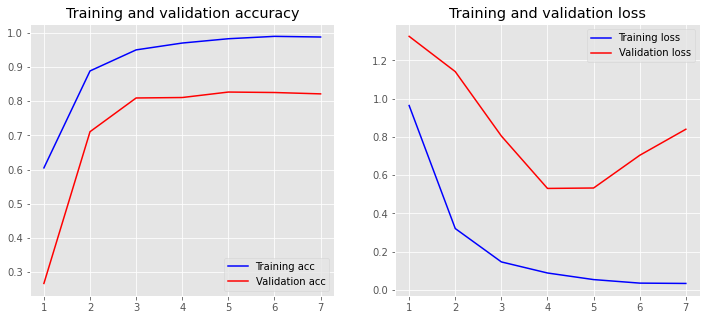

In [82]:
plot_history(history)

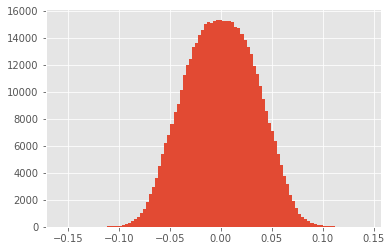

In [83]:
plt.hist(model.get_weights()[0].ravel(),100)
plt.show()

In [84]:
#model.weights

### 5.2.probabilities ditribution

In [85]:
pred_class = model_nn.predict(X_pd_sq_test)
pred_class[:5]

array([[8.3082047e-04, 9.9859470e-01, 2.3094617e-04, 3.4359889e-04],
       [5.9583078e-07, 9.9997711e-01, 1.9151425e-05, 3.0896160e-06],
       [9.9981314e-01, 6.4160868e-06, 2.6705895e-05, 1.5371334e-04],
       [9.4401884e-01, 7.5619045e-04, 1.4067979e-02, 4.1156907e-02],
       [9.9802077e-01, 2.9853386e-06, 1.9220756e-03, 5.4177883e-05]],
      dtype=float32)

This is probabilities of our output. We need to convert to crisp classes.

### 5.3.Class_prediction

In [86]:
# predict crisp classes for test set. Output will be 1-D
yhat_classes = model_nn.predict_classes(X_pd_sq_test, verbose=0)
yhat_classes[:10]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([1, 1, 0, 0, 0, 0, 3, 0, 1, 2])

In [87]:
#Other way to do it
y_test_class = np.argmax(y_test_ohe,axis=1)
y_pred_class = np.argmax(pred_class,axis=1)

In [88]:
# predicted classes
y_pred_class[:10]

array([1, 1, 0, 0, 0, 0, 3, 0, 1, 2])

In [89]:
# in form of class type
y_test_class[:10]

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 2])

In [90]:
# in matrix form
y_test_ohe[:10]

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [91]:
# real data
y_test[:10]

6252    e
4684    e
1731    b
4742    b
4521    b
6340    b
576     b
5202    b
6363    e
439     m
Name: category, dtype: object

- For our model, encoding scheme has been changed 
- b=0 ,e=1 , m=2 ,t=3
- This will help in decoding back our values

### 5.4.CLassification Report

In [92]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       702
           1       0.91      0.89      0.90       893
           2       0.72      0.73      0.73       295
           3       0.77      0.86      0.81       610

    accuracy                           0.83      2500
   macro avg       0.81      0.82      0.81      2500
weighted avg       0.84      0.83      0.83      2500



b=0 ,e=1 , m=2 ,t=3

### 5.5.Confusion Matrix

In [93]:
cm=confusion_matrix(y_test_class,y_pred_class)
cm

array([[550,  37,  40,  75],
       [ 24, 795,  26,  48],
       [ 29,  21, 216,  29],
       [ 48,  23,  17, 522]])

In [94]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

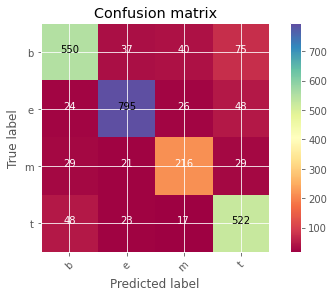

In [95]:
plot_confusion_matrix(cm, classes=['b', 'e','m','t'])

b=0 ,e=1 , m=2 ,t=3

# 6- Model Evaluation

Based on test set

In [96]:
#loading test feature and label data saved from previous notebooks
feature_test=pd.read_csv('test_data.csv')
label_test=pd.read_csv('test_label.csv')

In [97]:
print(feature_test.shape)
print(label_test.shape)

(84484, 2)
(84484, 1)


### transform feature data

In [98]:
feature_test.head(2)

,Unnamed: 0,title
0,153245,iPhone 6 Release Date Pushed Back Due to Issue...
1,308611,Samsung Galaxy S4 vs Galaxy S3: Budget-Friendl...


In [100]:
X_test_token = tokenizer.texts_to_sequences(feature_test.title)
pd.DataFrame(X_test_token).shape

(84484, 15)

In [101]:
pd.DataFrame(X_test_token).head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,126.0,206.0,118.0,422.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15.0,2360.0,164.0,4578.0,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
#pad_sequence:To keep all vectors of same length, I will use pad_sequence
X_pd_sq_test = pad_sequences(X_test_token,maxlen=MAX_SEQUENCE_LENGTH)
pd.DataFrame(X_pd_sq_test).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,126,206,118,422
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,2360,164,4578,2010
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,973
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,278,1388,3558
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,123,1421


In [103]:
print(X_pd_sq_test.shape)

(84484, 200)


### Transform Label data

In [104]:
y_test_ohe=one_hot_encode_object_array(label_test)
print(y_test_ohe.shape)

(84484, 4)


### Predictions

In [106]:
accr = model_nn.evaluate(X_pd_sq_test,y_test_ohe)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2641/2641 [==============================] - 136s 51ms/step - loss: 0.9693 - accuracy: 0.7328
Test set
  Loss: 0.969
  Accuracy: 0.733


### probabilities ditribution

In [105]:
pred_class = model_nn.predict(X_pd_sq_test)
pred_class[:5]

array([[1.1323378e-02, 2.8413063e-01, 3.9013938e-04, 7.0415586e-01],
       [6.4449654e-05, 4.3922746e-06, 4.1519284e-06, 9.9992704e-01],
       [4.7566229e-01, 5.6567937e-02, 2.6069477e-01, 2.0707501e-01],
       [2.2217144e-04, 2.6244382e-04, 9.9941409e-01, 1.0131958e-04],
       [9.7123766e-01, 7.4253313e-04, 6.6123837e-05, 2.7953761e-02]],
      dtype=float32)

### Class_prediction

In [107]:
# predict crisp classes for test set. Output will be 1-D
yhat_classes = model_nn.predict_classes(X_pd_sq_test, verbose=0)
yhat_classes[:10]

array([3, 3, 0, 2, 0, 1, 2, 3, 0, 1])

In [108]:
#Other way to do it
y_test_class = np.argmax(y_test_ohe,axis=1)
y_pred_class = np.argmax(pred_class,axis=1)

### Classification Report

In [109]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.75      0.66      0.70     23367
           1       0.84      0.81      0.82     30300
           2       0.48      0.74      0.58      9207
           3       0.73      0.70      0.72     21610

    accuracy                           0.73     84484
   macro avg       0.70      0.73      0.71     84484
weighted avg       0.75      0.73      0.74     84484



### Confusion Matrix

In [110]:
cm=confusion_matrix(y_test_class,y_pred_class)
cm

array([[15441,  2000,  2874,  3052],
       [ 1562, 24488,  2306,  1944],
       [  818,   950,  6822,   617],
       [ 2637,  1684,  2131, 15158]])

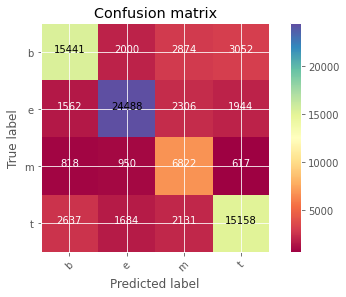

In [111]:
plot_confusion_matrix(cm, classes=['b', 'e','m','t'])

### 6-API Idea

- key: text
- output1: class prediction
- output2: probability of each class (higher is better)

In [120]:
texts=["Coronavirus: Two million global deaths 'not impossible' even with vaccine, warns WHO"]

In [121]:
text_token = tokenizer.texts_to_sequences(texts)
text_features=pad_sequences(text_token,maxlen=MAX_SEQUENCE_LENGTH)

In [122]:
score = model_nn.predict(text_features)
score

array([[0.7269321 , 0.08764877, 0.13764837, 0.04777085]], dtype=float32)

In [123]:
pred_class = np.argmax(score,axis=1)
pred_class

array([0])

In [124]:
prob=score.max(axis=1)
prob

array([0.7269321], dtype=float32)

b=0 ,e=1 , m=2 ,t=3

In [125]:
result=texts
result=pd.DataFrame(result,columns=["text"])
result["news-type"]=pred_class
result["news-type"]=result['news-type'].map({0 : "b", 1 : "e", 2 :"m", 3:"t"})
result["probability"]=prob

In [126]:
result

,text,news-type,probability
0,Coronavirus: Two million global deaths 'not im...,b,0.726932


In [119]:
json_table = result.to_json(orient='records')  
json_table

'[{"text":"YouTube updates to include crowd-funding options","news-type":"b","probability":0.5653631687}]'